In [ ]:
# Scraper 설치
!pip install pyLDAvis # LDA 시각화
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git # 한국어 띄어쓰기 패키지(pykospacing)
!pip install git+https://github.com/ssut/py-hanspell.git # 한국어 Norm : 맞춤법 교정(hanspell)

# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!pip install konlpy

! pip install MeCab
# 오류나면 [런타임 다시 시작] 누르고 다시 설치 필요 없이 진행 !!!!!

In [ ]:
# Data 불러오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/비정형

/content/drive/MyDrive/Colab Notebooks/비정형


In [ ]:
!pip install numpy==1.24.2 --force

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.2 which is incompatible.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/na

In [ ]:
import utils.LDA_utils as lda_utils

## 전처리 필요 라이브러리
import re
import time
import datetime
import numpy as np
import pandas as pd

# 단어 임베딩
from sklearn.manifold import TSNE
from gensim import models
import itertools

# 기타
from tqdm import tqdm
import warnings # 경고 메시지 무시
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'

## Main

Topic modeling

In [ ]:
# OTT 선택, 전체로 할 시 None 으로 기입
# OTT = 'tiving'
OTT = None

# 토픽 결정 수
num_topics = 5

# 불용어
add_stopwords_list = ['티빙', '넷플릭스', '웨이브', '쿠팡', '쿠팡플레이', '디즈니', '나무',
                      '디즈니플러스', '애플리케이션', '개발자', '도도', '슈슈', '휴휴',
                      '옥수수', '라프텔', '라프']

timeslices=[4097, 16623, 3051]

In [ ]:
# 데이터 불러오기
df = pd.read_csv('./data/review_data.csv', encoding='utf-8-sig')
if OTT:
  df_ott = df[df['ott']== OTT]
else:
  df_ott = df.copy()


### 리뷰 기간 조정 및 결측치 처리 ###
df_ott = lda_utils.date_extract(df_ott, start_day='2021-11-12', printing=True)

### 토픽모델링 ###
token_data = lda_utils.Data_processing(df_ott) # 전처리 시작
tokenized_data, _ = token_data.get_token(add_stopwords_list)

2021: 5044 rows

2022: 18833 rows

2023: 6684 rows

ko_language done..
replace_word done..
tokenize done..
remove_stopwords done..


In [ ]:
# Corpus 합쳐서 따로 Word Embedding
# tokenized_data = 모든 문장 토큰들 집합 [[1], [2], [3]] 형

# 1. Word2Vec

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences = tokenized_data, vector_size = 300, window = 5, min_count = 2, workers = 4, sg = 0)

# model.wv.save_word2vec_format('./data/word2vec_model') # 모델 저장
# loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

print(model.wv.most_similar('손흥민'))


[('토트넘', 0.9913099408149719), ('축구', 0.967329204082489), ('우롱', 0.948445200920105), ('세비야', 0.9456140995025635), ('서버', 0.940220296382904), ('뜬금', 0.9391071200370789), ('네이버', 0.9279732704162598), ('절차', 0.9274980425834656), ('행태', 0.9262815117835999), ('윤석열', 0.9235817790031433)]


In [ ]:
# Fasttext

from gensim.models.fasttext import FastText

fasttext_model = FastText(sentences = tokenized_data, min_count=2, vector_size=300, workers = 4)
print(fasttext_model)

print(fasttext_model.wv.most_similar('손흥민'))


FastText<vocab=4769, vector_size=300, alpha=0.025>
[('토트넘', 0.99671870470047), ('축구', 0.9791788458824158), ('서버', 0.9641250967979431), ('긴', 0.9615797400474548), ('절차', 0.9494115114212036), ('네이버', 0.948626697063446), ('우롱', 0.9477217197418213), ('네이', 0.9469528198242188), ('사업자', 0.9457647204399109), ('대회', 0.9457535743713379)]


In [ ]:
# 토픽모델링 시작
lda = lda_utils.Model(tokenized_data, num_topics=num_topics) # 토픽모델링 시작
LDAseq = lda.LDAseqmodel(timeslices=timeslices)

In [ ]:
# 학습된 토픽들과 해당하는 단어들 출력
for t in range(3):
    topics = LDAseq.print_topics(time=t)
    print("---------------")
    for topic in topics:
        print(topic)

topic_table
topic_table

Word Embedding

In [ ]:
import itertools

t2021 = pd.read_csv('./data/2021_v3.csv', encoding = 'euc-kr')
t2022 = pd.read_csv('./data/2022_v3.csv', encoding = 'euc-kr')
t2023 = pd.read_csv('./data/2023_v3.csv', encoding = 'euc-kr')

def normalize(topic_):
    topic_ = topic_.iloc[0:20, :]
    for column in topic_:
        if type(topic_[column][0]) != str:
            x = topic_[column].values.reshape(-1, 1)
            tot = x.sum()
            x = x/tot
            topic_[column] = x
    return topic_

t2021 = normalize(t2021)
t2022 = normalize(t2022)
t2023 = normalize(t2023)

def wordlist(data_):
    v1 = data_['1_topic'].values
    v2 = data_['2_topic'].values
    v3 = data_['3_topic'].values
    v4 = data_['4_topic'].values
    # v5 = data_['5_topic'].values
    wordlist_ = list(set(list(itertools.chain(v1, v2 ,v3, v4)))) # v5
    return wordlist_

words = wordlist(t2021)


In [ ]:
word_sentiment = pd.read_csv('./data/words_sentiment_v3.csv', index_col = 0)

w2v_embedding = np.array([])
fast_embedding = np.array([])
i = 0
for word in words:
    if i == len(words):
        break
    w2v_embedding = np.append(w2v_embedding, model.wv.get_vector(word))
    fast_embedding = np.append(fast_embedding, fasttext_model.wv.get_vector(word))
    i += 1

# 300차원 벡터로 표상, embedding reshape
w2v_embedding = w2v_embedding.reshape(len(words), 300)
fast_embedding = fast_embedding.reshape(len(words), 300)

word_sentiment_2 = pd.DataFrame(index = range(len(words)), columns = ['word', 'BERT', 'Electra', 'BERT_pos', 'Electra_pos'])
word_sentiment_2['word'] = words

for i in range(len(words)):
  word = words[i]
  for j in range(len(word_sentiment)):
    if word_sentiment['word'][j] == word:
      word_sentiment_2['BERT'][i] = word_sentiment['BERT'][j]
      word_sentiment_2['Electra'][i] = word_sentiment['Electra'][j]

positive = pd.read_csv('./data/SA.csv', index_col = 0)
positive = positive.sort_values(by = 'keyword').reset_index(drop = True)

word_sentiment_2 = word_sentiment_2.sort_values(by ='word').reset_index(drop = True)

for i in range(len(words)):
  word = words[i]
  for j in range(len(positive)):
    if positive['keyword'][j] == word:
      word_sentiment_2['BERT_pos'][i] = positive['BERT'][j]
      word_sentiment_2['Electra_pos'][i] = positive['Electra'][j]


words.sort()
word_sentiment = word_sentiment_2

In [ ]:
word_sentiment['BERT_pos'] = positive['BERT'] * 50 + 50
word_sentiment['Electra_pos'] = positive['Electra']* 50 + 50
# print(len(word_sentiment))


def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]


def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_ = n/100
    rgb_colors = list(map(np.int_, 255*((1-mix_)*c2_rgb + (mix_*c1_rgb))))
    colorcode = "#"
    for val in rgb_colors:
      colorcode = colorcode + "".join(format(val, "02x"))
    return colorcode

word_sentiment
word_sentiment.to_csv('./data/word_sentiment_final.csv')

In [ ]:
tsne = TSNE(perplexity = 5, n_components = 2, init = 'pca', learning_rate = 100) #, n_iter = 10000, learning_rate = 100, early_exaggeration = 5)
w2v_word_embed = tsne.fit_transform(w2v_embedding)
fast_word_embed = tsne.fit_transform(fast_embedding)

w2v_dict = dict(zip(words, w2v_word_embed))
fast_dict = dict(zip(words, fast_word_embed))

def topicval(list_, dict_):
    df_ = pd.DataFrame(index = range(len(list_)), columns = ['Weight', 'Word', 'Val'])
    df_['Weight'] = list_.iloc[:, 1]
    df_['Word'] = list_.iloc[:, 0].map(dict_)
    df_['Val'] = df_['Weight'] * df_['Word']
    return [df_['Val'].sum()]

def gettopic(data_, dict_):
    tplist_ = np.array([])
    for i in range(0, 8, 2): # 8 = Topic 개수 * 2
        data_i = data_.iloc[:, i:i+2]
        tplist_ = np.append(tplist_, [topicval(data_i, dict_)])
        tplist_ = tplist_.reshape((-1, 2))
    return tplist_

w_2021 = gettopic(t2021, w2v_dict)
w_2022 = gettopic(t2022, w2v_dict)
w_2023 = gettopic(t2023, w2v_dict)
w_all = np.concatenate([w_2021, w_2022, w_2023], axis = 0)

f_2021 = gettopic(t2021, fast_dict)
f_2022 = gettopic(t2022, fast_dict)
f_2023 = gettopic(t2023, fast_dict)
f_all = np.concatenate([f_2021, f_2022, f_2023], axis = 0)


In [ ]:
w_all

array([[-20.60351944,  21.16385269],
       [-20.66743851,  -9.00109291],
       [  0.27352774, -28.11698341],
       [ 30.67371941,  23.42353821],
       [-26.11314774,  19.1321888 ],
       [-20.6256237 ,  -8.9260025 ],
       [  3.11750984, -27.63378143],
       [ 29.47090721,  22.76813698],
       [-27.60760689,  18.72080231],
       [-20.5862751 ,  -8.86738968],
       [  3.24223995, -27.99001694],
       [ 28.82641602,  22.43069649]])

In [ ]:
# 한글 깨짐 해결

import matplotlib.font_manager as fm
from matplotlib import rc

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]


['/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf',
 '/usr/share/fonts/truetype/humor-sa

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

topic_label = []
for i in range(12): # Topic 개수 * 3
    if i < 4:
        text = f'21-{i+1}' # < Topic 개수
    elif 3 < i < 8:
        text = f'22-{i-3}' # Topic개수 -1 < i < Topic개수 *2
    elif 7 < i:
        text = f'23-{i-7}' # Topic개수 * 2 -1 < i
    topic_label.append(text)

def coloring(number_):
    if number_ == 0:
      return 'red'
    elif number_ == 1:
      return 'blue'


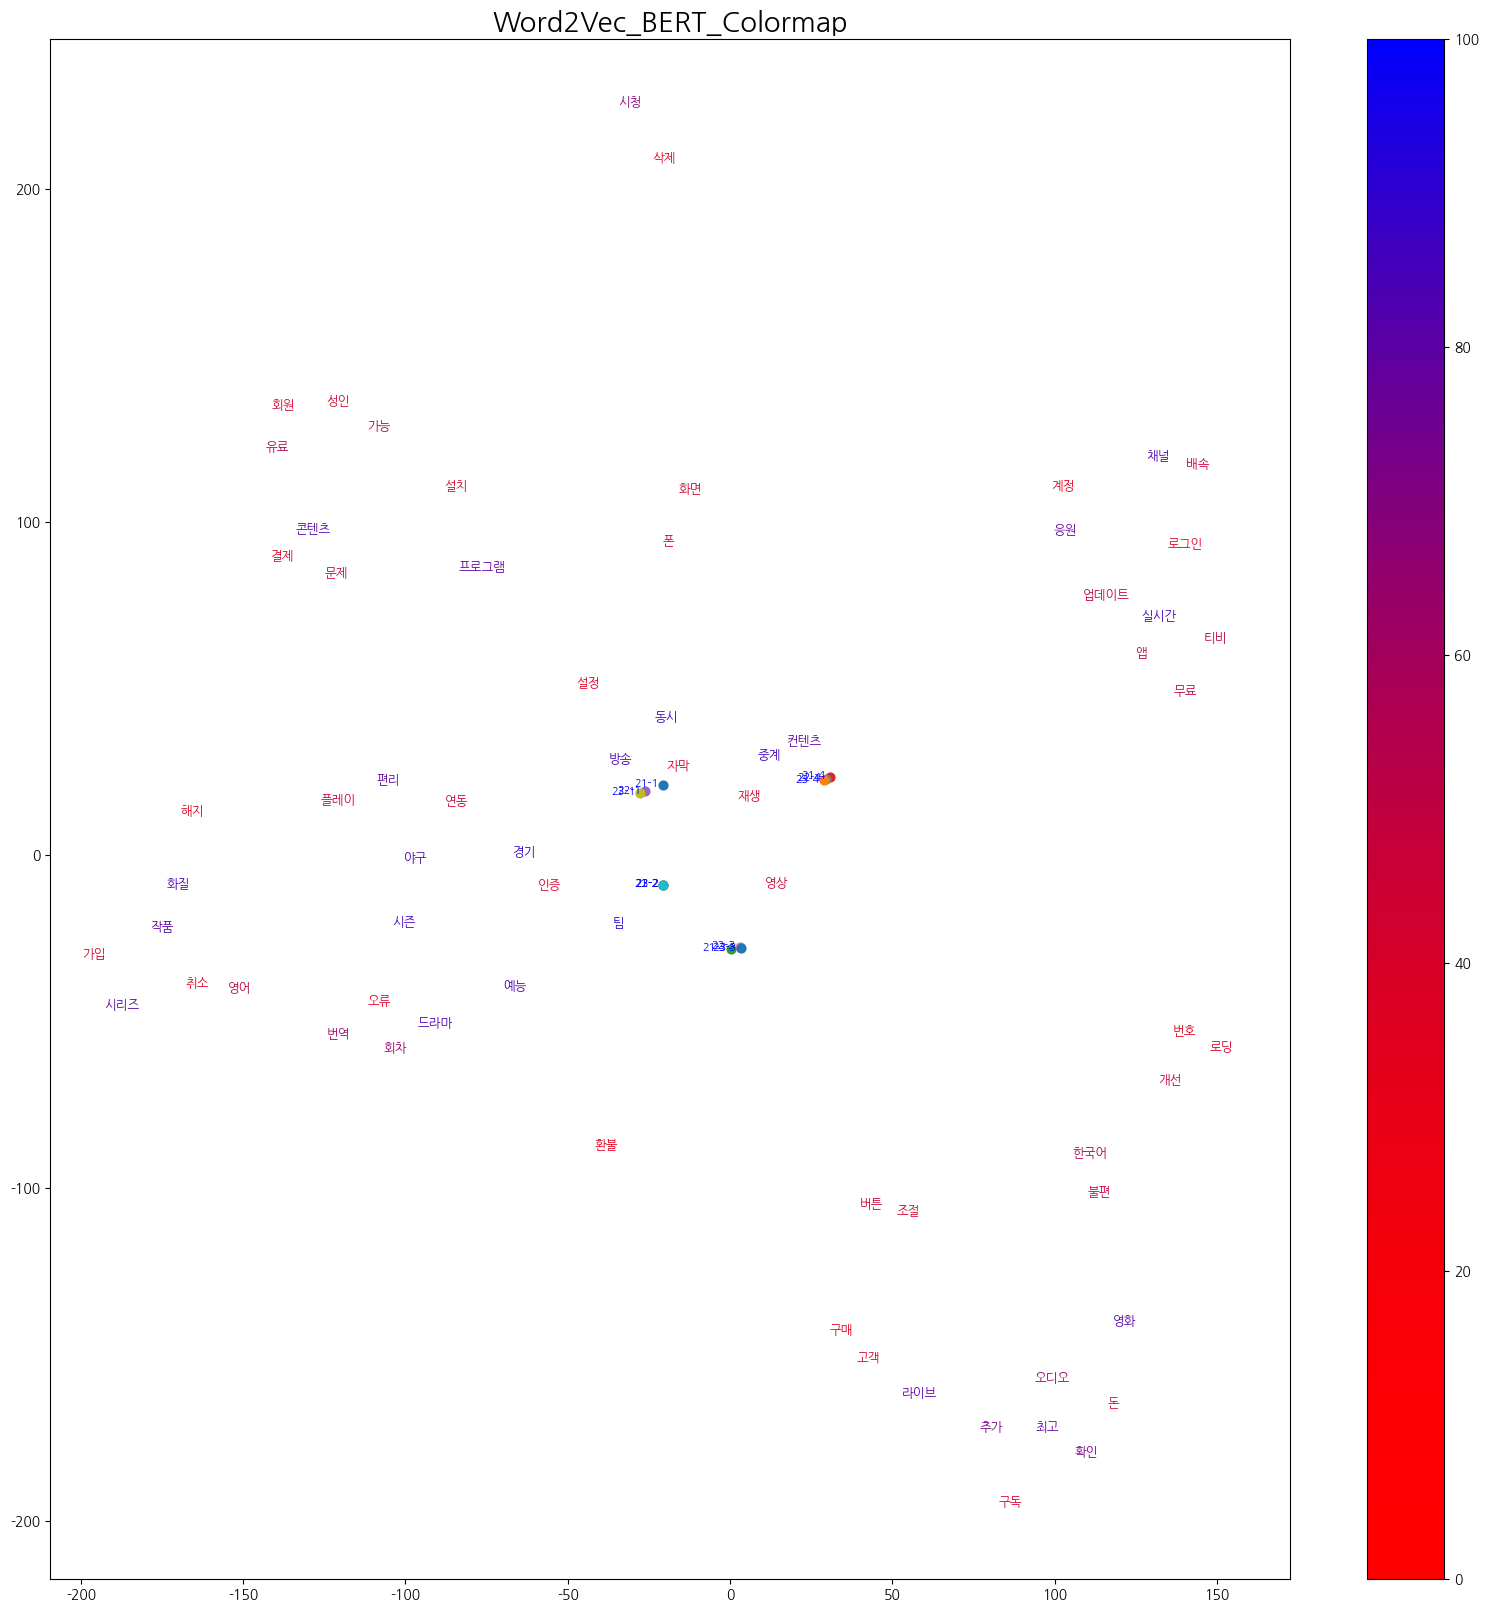

In [ ]:
# Word2Vec BERT
import matplotlib.colors as mcl
import matplotlib.cm as cm
import matplotlib as mpl

color1 = "#0000FF"
color2 = "#FF0000"

cmap = mcl.LinearSegmentedColormap.from_list('my_cmap', [color2, color1], gamma=2)
norm = mpl.colors.Normalize(vmin=0, vmax=100)
colormapping = cm.ScalarMappable(norm=norm, cmap=cmap)


fig = plt.figure(figsize=(20, 20))  # in inches
for i, label in enumerate(words):
    x, y = w2v_word_embed[i, :] # word2vec
    plt.scatter(x, y, color = 'white')
    plt.annotate(label,
                  xy=(x, y),
                  xytext=(0, 0),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  color = get_color_gradient(color1, color2, word_sentiment['BERT_pos'][i]),
                  fontsize = 9)
for i, label in enumerate(topic_label):
    x, y = w_all[i, :] # word2vec
    plt.scatter(x, y, marker = 'o', s = 40) # color = 'limegreen',
    plt.annotate(label,
                 color = 'b',
                  xy=(x, y),
                  xytext=(-3, -3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize = 8)

plt.title('Word2Vec_BERT_Colormap', size = 20)
cbar = fig.colorbar(colormapping, ax=plt.gca())
# plt.savefig('./data/BERT_W2V_Bar_New.png')


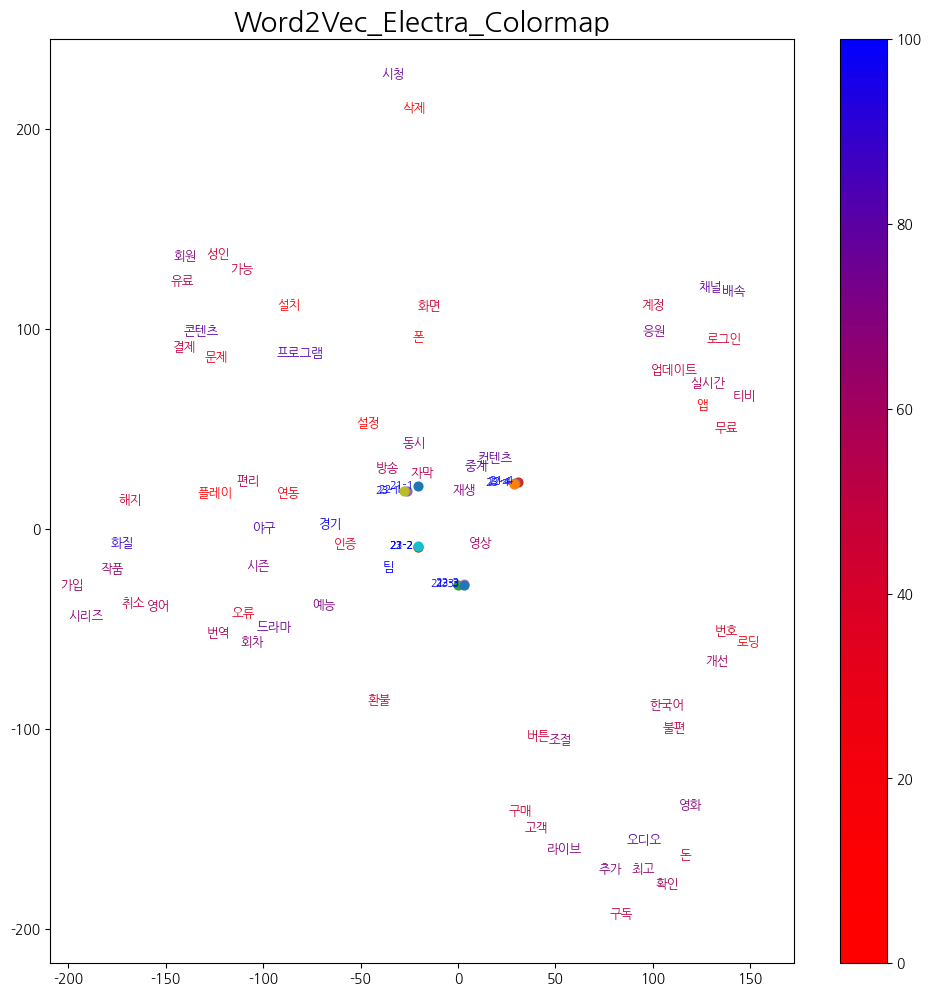

In [ ]:
# Word2Vec Electra
color1 = "#0000FF"
color2 = "#FF0000"

cmap = mcl.LinearSegmentedColormap.from_list('my_cmap', [color2, color1], gamma=2)
norm = mpl.colors.Normalize(vmin=0, vmax=100)
colormapping = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(12, 12))  # in inches
for i, label in enumerate(words):
    x, y = w2v_word_embed[i, :] # word2vec
    plt.scatter(x, y, color = 'white')
    plt.annotate(label,
                  xy=(x, y),
                  xytext=(0, 0),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  color = get_color_gradient(color1, color2, word_sentiment['Electra_pos'][i]),
                  fontsize = 9)
for i, label in enumerate(topic_label):
    x, y = w_all[i, :] # word2vec
    plt.scatter(x, y, marker = 'o', s = 40) # color = 'limegreen',
    plt.annotate(label,
                 color = 'b',
                  xy=(x, y),
                  xytext=(-3, -3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize = 8)

plt.title('Word2Vec_Electra_Colormap', size = 20)
cbar = fig.colorbar(colormapping, ax=plt.gca())

plt.savefig('./data/Electra_W2V_Bar_New.png')

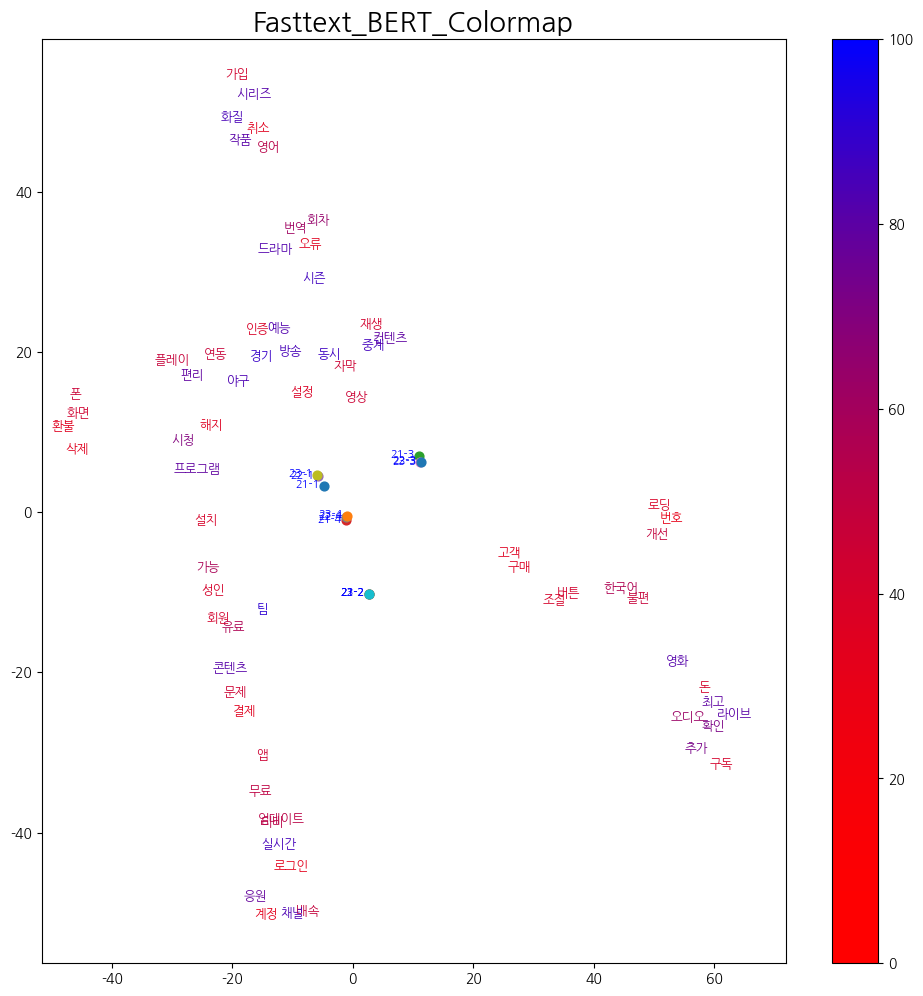

In [ ]:
# Fasttext BERT

color1 = "#0000FF"
color2 = "#FF0000"

cmap = mcl.LinearSegmentedColormap.from_list('my_cmap', [color2, color1], gamma=2)
norm = mpl.colors.Normalize(vmin=0, vmax=100)
colormapping = cm.ScalarMappable(norm=norm, cmap=cmap)


fig = plt.figure(figsize=(12, 12))  # in inches
for i, label in enumerate(words):
    x, y = fast_word_embed[i, :] # fasttext
    plt.scatter(x, y, color = 'white')
    plt.annotate(label,
                  xy=(x, y),
                  xytext=(0, 0),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  color = get_color_gradient(color1, color2, word_sentiment['BERT_pos'][i]),
                  fontsize = 9)
for i, label in enumerate(topic_label):
    x, y = f_all[i, :] # fasttext
    plt.scatter(x, y, marker = 'o', s = 40) # color = 'limegreen',
    plt.annotate(label,
                 color = 'b',
                  xy=(x, y),
                  xytext=(-3, -3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize = 8)

plt.title('Fasttext_BERT_Colormap', fontsize = 20)
cbar = fig.colorbar(colormapping, ax=plt.gca())
plt.savefig('./data/BERT_FastText_Bar_New.png')

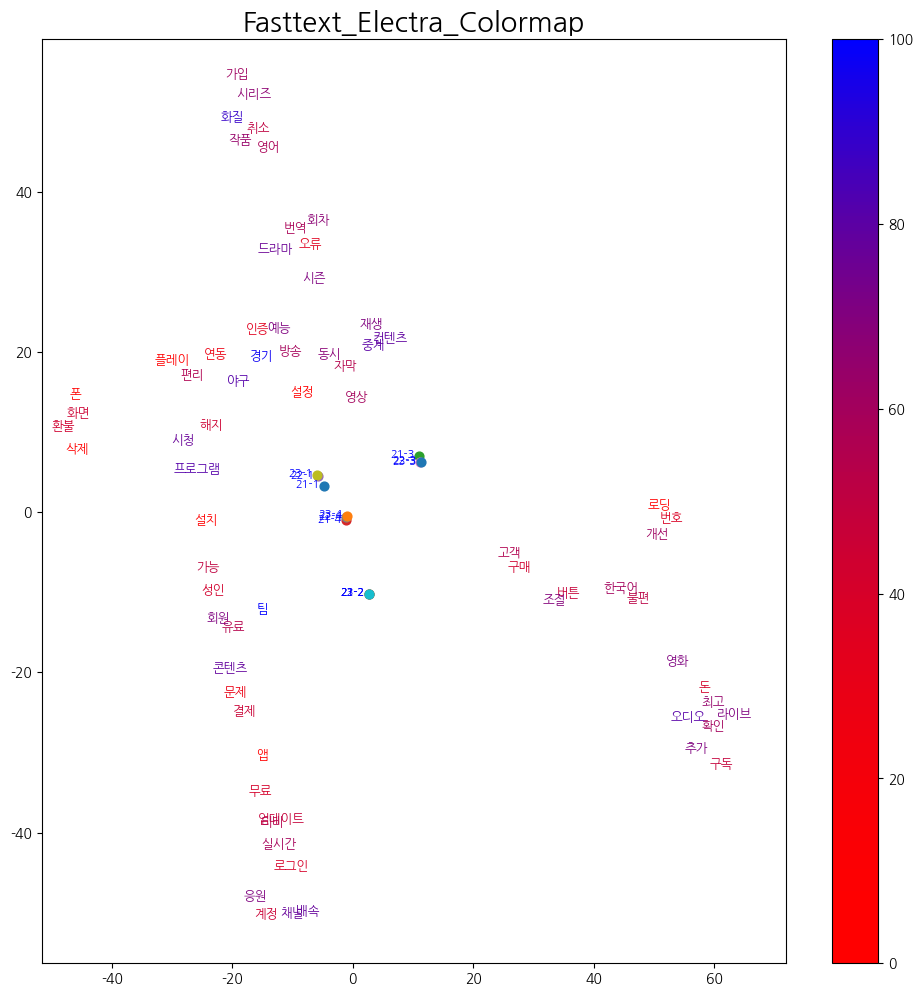

In [ ]:
# Fasttext Electra

color1 = "#0000FF"
color2 = "#FF0000"

cmap = mcl.LinearSegmentedColormap.from_list('my_cmap', [color2, color1], gamma=2)
norm = mpl.colors.Normalize(vmin=0, vmax=100)
colormapping = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(12, 12))  # in inches
for i, label in enumerate(words):
    x, y = fast_word_embed[i, :] # fasttext
    plt.scatter(x, y, color = 'white')
    plt.annotate(label,
                  xy=(x, y),
                  xytext=(0, 0),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  color = get_color_gradient(color1, color2, word_sentiment['Electra_pos'][i]),
                  fontsize = 9)
for i, label in enumerate(topic_label):
    x, y = f_all[i, :] # fasttext
    plt.scatter(x, y, marker = 'o', s = 40) # color = 'limegreen',
    plt.annotate(label,
                 color = 'b',
                  xy=(x, y),
                  xytext=(-3, -3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize = 8)

plt.title('Fasttext_Electra_Colormap', fontsize = 20)
cbar = fig.colorbar(colormapping, ax=plt.gca())
plt.savefig('./data/Electra_FastText_Bar_New.png')


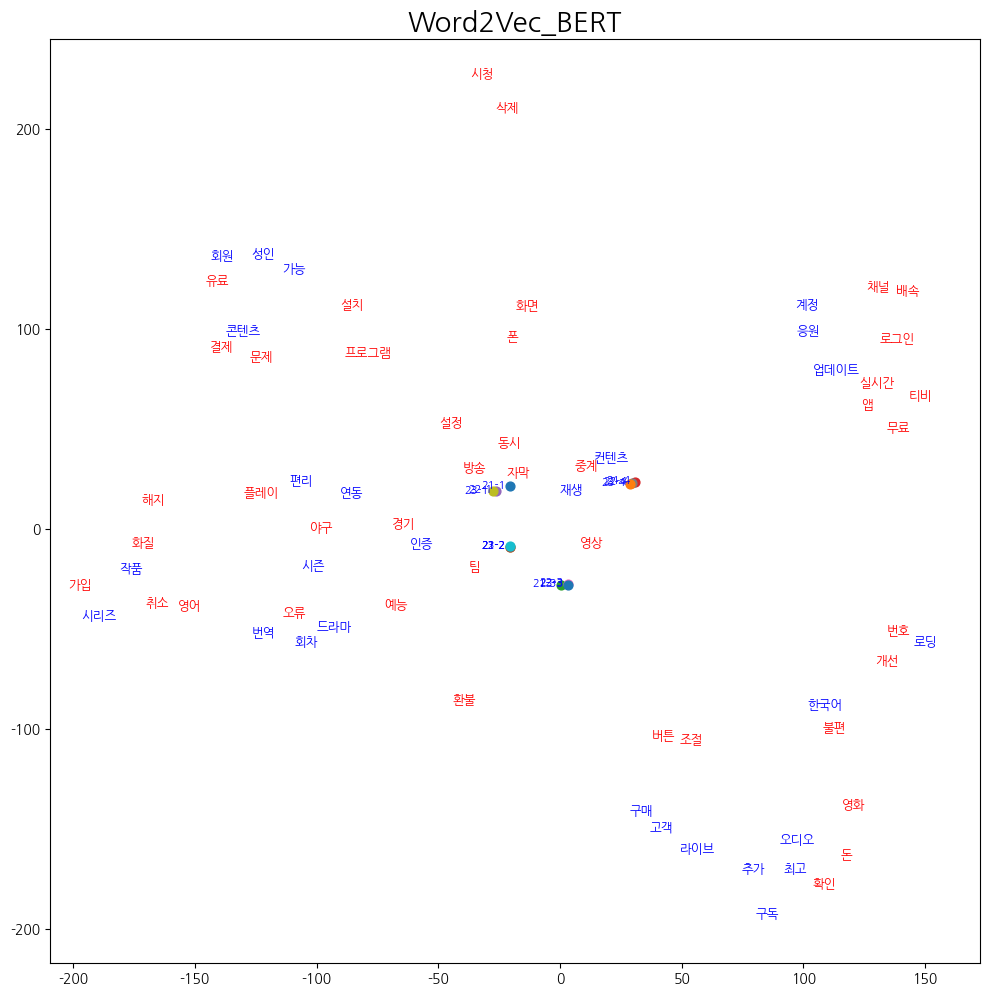

In [ ]:
# Word2Vec

plt.figure(figsize=(12, 12))  # in inches
for i, label in enumerate(words):
    x, y = w2v_word_embed[i, :] # word2vec
    plt.scatter(x, y, color = 'white')
    plt.annotate(label,
                  xy=(x, y),
                  xytext=(0, 0),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  color = coloring(word_sentiment['BERT'][i]),
                  fontsize = 9)
for i, label in enumerate(topic_label):
    x, y = w_all[i, :] # word2vec
    plt.scatter(x, y, marker = 'o', s = 40) # color = 'limegreen',
    plt.annotate(label,
                 color = 'b',
                  xy=(x, y),
                  xytext=(-3, -3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize = 8)

plt.title('Word2Vec_BERT', size = 20)
plt.savefig('./data/BERT_W2V_01_New.png')


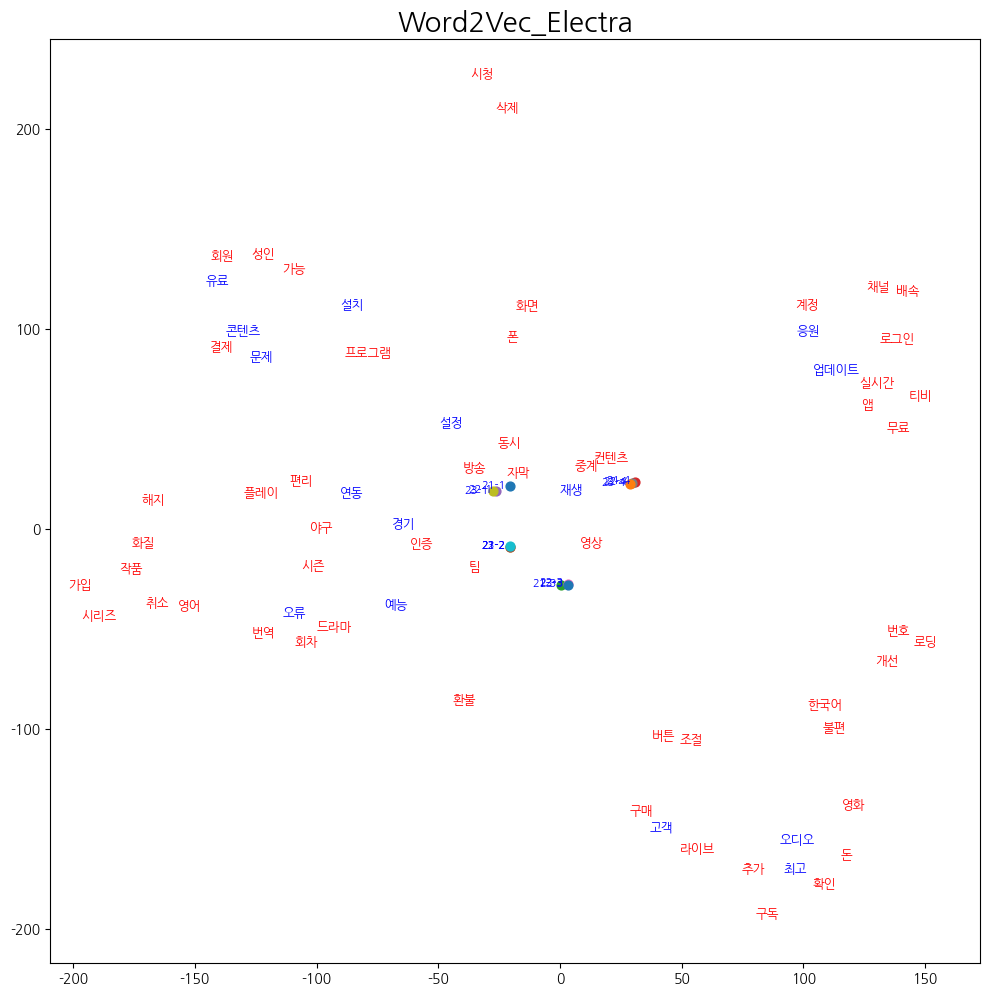

In [ ]:
# Word2Vec

plt.figure(figsize=(12, 12))  # in inches
for i, label in enumerate(words):
    x, y = w2v_word_embed[i, :] # word2vec
    plt.scatter(x, y, color = 'white')
    plt.annotate(label,
                  xy=(x, y),
                  xytext=(0, 0),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  color = coloring(word_sentiment['Electra'][i]),
                  fontsize = 9)
for i, label in enumerate(topic_label):
    x, y = w_all[i, :] # word2vec
    plt.scatter(x, y, marker = 'o', s = 40) # color = 'limegreen',
    plt.annotate(label,
                 color = 'b',
                  xy=(x, y),
                  xytext=(-3, -3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize = 8)

plt.title('Word2Vec_Electra', size = 20)
plt.savefig('./data/Electra_W2V_01_New.png')

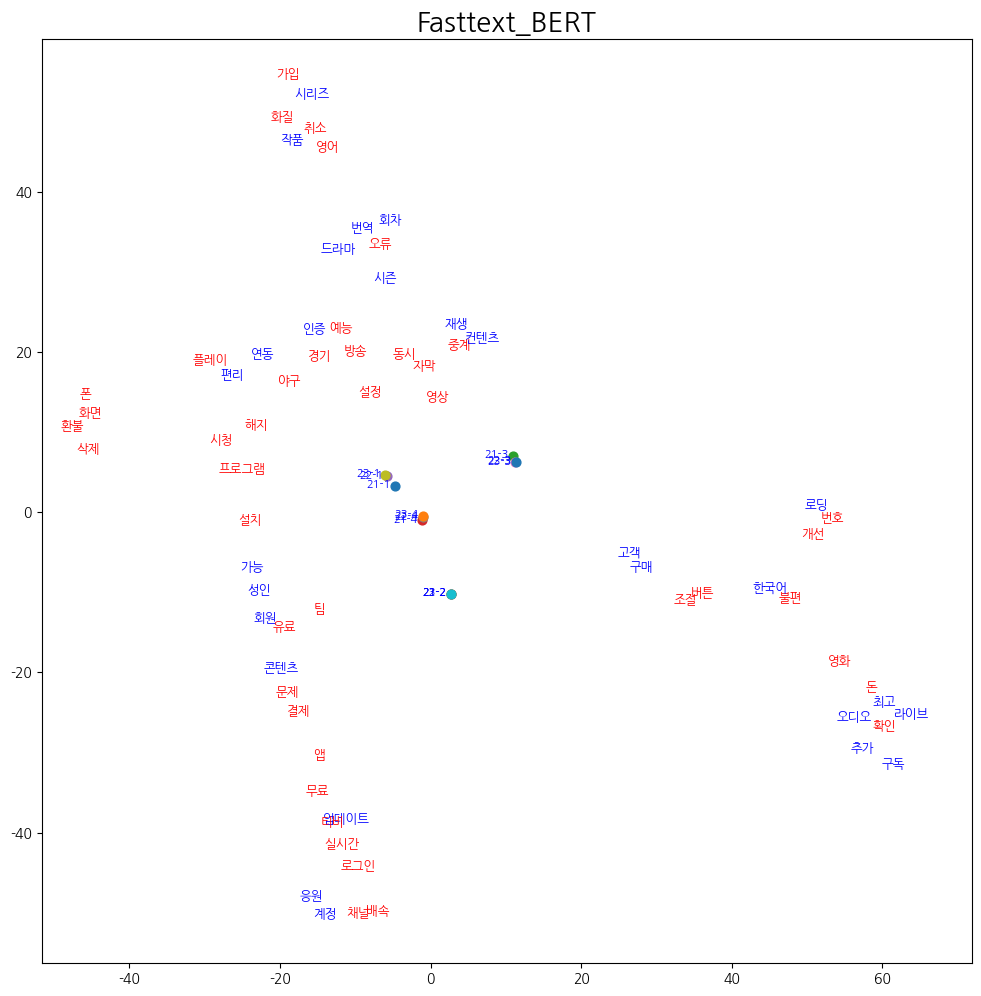

In [ ]:
# Fasttext

plt.figure(figsize=(12, 12))  # in inches
for i, label in enumerate(words):
    x, y = fast_word_embed[i, :] # fasttext
    plt.scatter(x, y, color = 'white')
    plt.annotate(label,
                  xy=(x, y),
                  xytext=(0, 0),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  color = coloring(word_sentiment['BERT'][i]),
                  fontsize = 9)
for i, label in enumerate(topic_label):
    x, y = f_all[i, :] # fasttext
    plt.scatter(x, y, marker = 'o', s = 40) # color = 'limegreen',
    plt.annotate(label,
                 color = 'b',
                  xy=(x, y),
                  xytext=(-3, -3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize = 8)

plt.title('Fasttext_BERT', fontsize = 20)
plt.savefig('./data/BERT_FastText_01_New.png')

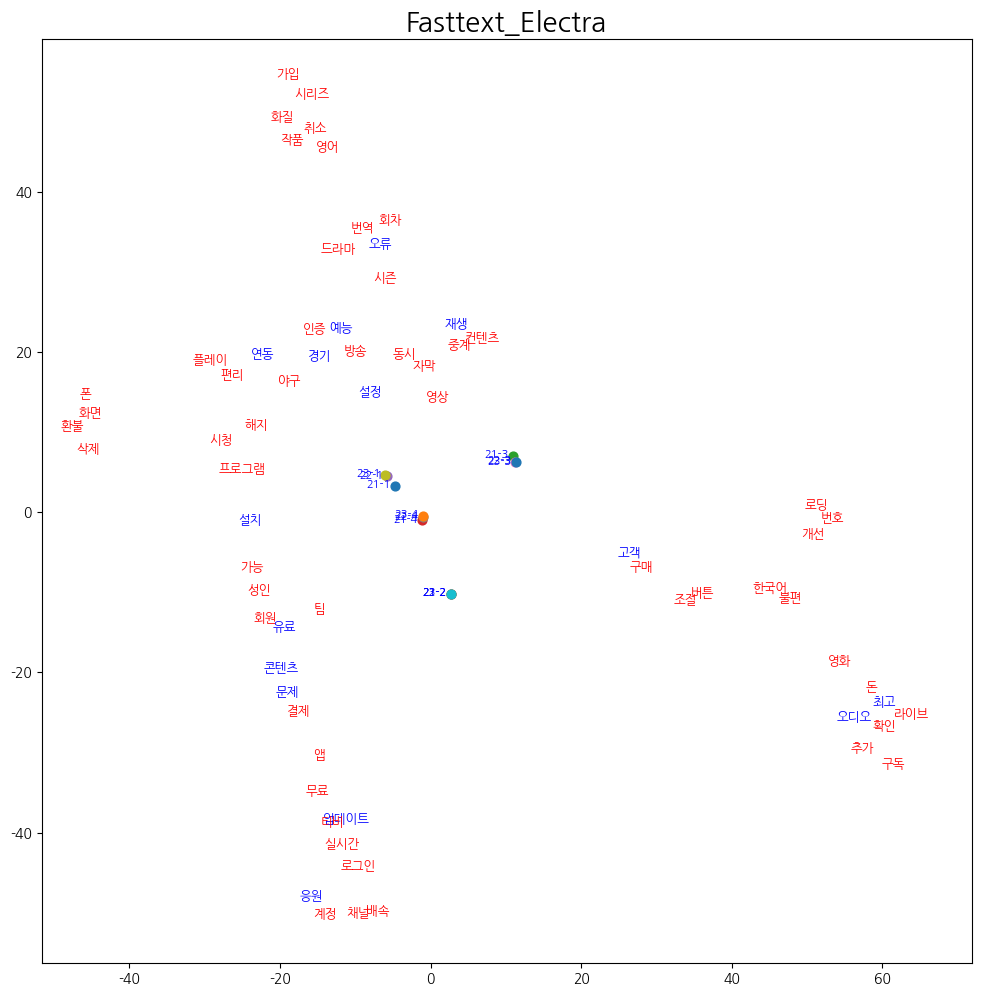

In [ ]:
# Fasttext

plt.figure(figsize=(12, 12))  # in inches
for i, label in enumerate(words):
    x, y = fast_word_embed[i, :] # fasttext
    plt.scatter(x, y, color = 'white')
    plt.annotate(label,
                  xy=(x, y),
                  xytext=(0, 0),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  color = coloring(word_sentiment['Electra'][i]),
                  fontsize = 9)
for i, label in enumerate(topic_label):
    x, y = f_all[i, :] # fasttext
    plt.scatter(x, y, marker = 'o', s = 40) # color = 'limegreen',
    plt.annotate(label,
                 color = 'b',
                  xy=(x, y),
                  xytext=(-3, -3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                  fontsize = 8)

plt.title('Fasttext_Electra', fontsize = 20)
plt.savefig('./data/Electra_Fasttext_01_New.png')